In [2]:
from rag_eval import ChunkDataHandler

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow_hub as hub
import tensorflow_text as tftext
import tensorflow as tf
import sys
sys.path.append("..")
import numpy as np

from emb_src.plots import plot_embeddings_2d
from emb_src.chunk_encoder import ChunkEncoder, HyDEChunkEncoder, chunk2query_cosine_similarity

# check if GPU is available
tf.config.list_physical_devices('GPU')

2025-06-24 13:57:27.989341: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-24 13:57:29.041597: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-24 13:57:29.458682: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-24 13:57:29.587775: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-24 13:57:30.309228: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
chunk_encoder = ChunkEncoder()
docs_names = chunk_encoder.get_doc_names()

I0000 00:00:1750766261.565906   18363 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1750766261.566033   18363 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1750766261.566060   18363 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1750766262.315481   18363 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1750766262.315826   18363 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-06-24

### multiple docs relation maps

8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step


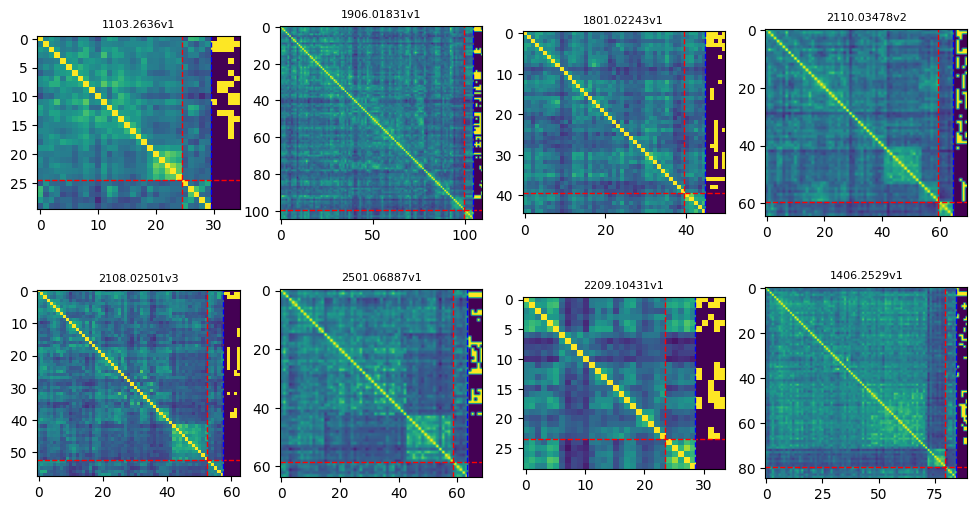

In [ ]:
import random
# Relations with queries and labels attatched at the end
rows = 2
cols = 4

fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3.1))

random_docs = random.sample(docs_names, rows * cols)
pb = tf.keras.utils.Progbar(len(random_docs))
for i, ax in enumerate(axs.flat):
    doc_name = random_docs[i]
    encodings = chunk_encoder.encode_doc(doc_name, return_all=True)
    sections = tf.concat([encodings['encoded_chunks'], encodings['encoded_queries']], axis=0)
    similarity = chunk2query_cosine_similarity(sections, sections)

    chunks_num = len(encodings['encoded_chunks'])
    queries_num = len(encodings['encoded_queries'])
    similarity = tf.concat([similarity, tf.cast(tf.pad(encodings['chunks_labels'], [[0, queries_num], [0, 0]]), similarity.dtype)], axis=1)

    pb.add(1)
    ax.imshow(similarity)
    ax.axhline(y=chunks_num - 0.5, color='red', linestyle='--', linewidth=1)  # Marker for query start"
    ax.axvline(x=chunks_num - 0.5, color='red', linestyle='--', linewidth=1)  # Marker for query start"
    ax.axvline(x=chunks_num+queries_num - 0.5, color='red', linestyle='--', linewidth=1)  # Marker for labels start"
    #ax.set_axis_off()
    ax.set_title(doc_name, fontsize=8)

### thresholded self similarity maps

8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step


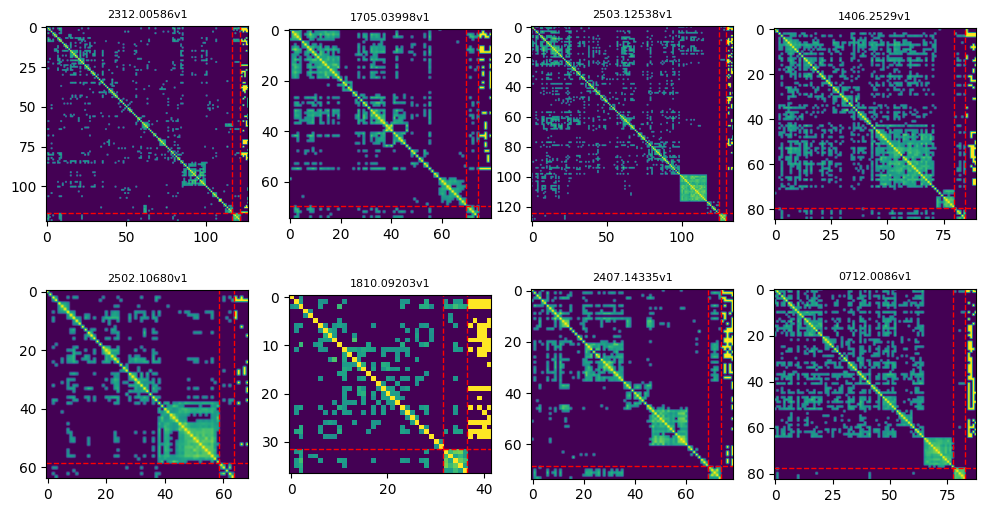

In [35]:
import random
# Relations with queries and labels attatched at the end
threshold = 0.5
rows = 2
cols = 4

fig, axs = plt.subplots(rows, cols, figsize=(cols*3, rows*3.1))

random_docs = random.sample(docs_names, rows * cols)
pb = tf.keras.utils.Progbar(len(random_docs))
for i, ax in enumerate(axs.flat):
    doc_name = random_docs[i]
    encodings = chunk_encoder.encode_doc(doc_name, return_all=True)
    sections = tf.concat([encodings['encoded_chunks'], encodings['encoded_queries']], axis=0)
    similarity = chunk2query_cosine_similarity(sections, sections)
    similarity = tf.where(similarity > threshold, similarity, tf.zeros_like(similarity))

    chunks_num = len(encodings['encoded_chunks'])
    queries_num = len(encodings['encoded_queries'])
    similarity = tf.concat([similarity, tf.cast(tf.pad(encodings['chunks_labels'], [[0, queries_num], [0, 0]]), similarity.dtype)], axis=1)

    pb.add(1)
    ax.imshow(similarity)
    ax.axhline(y=chunks_num - 0.5, color='red', linestyle='--', linewidth=1)  # Marker for query start"
    ax.axvline(x=chunks_num - 0.5, color='red', linestyle='--', linewidth=1)  # Marker for query start"
    ax.axvline(x=chunks_num+queries_num - 0.5, color='red', linestyle='--', linewidth=1)  # Marker for labels start"
    #ax.set_axis_off()
    ax.set_title(doc_name, fontsize=8)

### Next chunk similarity

(23,)


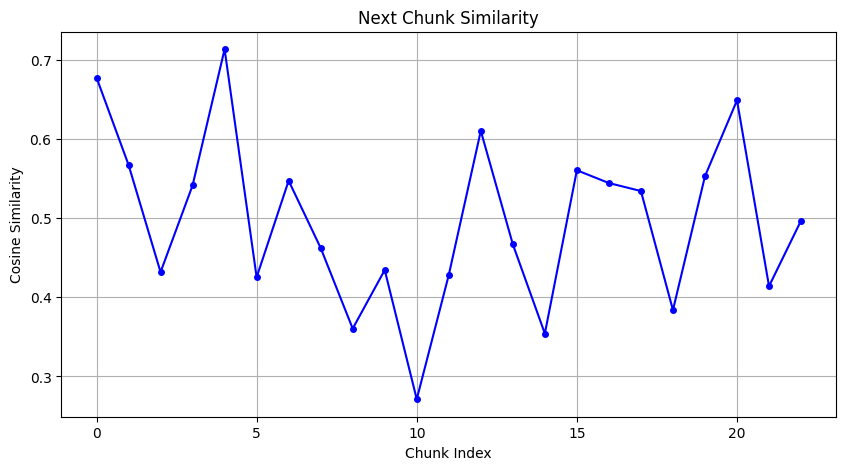

In [32]:
encodings = chunk_encoder.encode_doc('2209.10431v1', return_all=True)
similarity = chunk2query_cosine_similarity(encodings['encoded_chunks'], encodings['encoded_chunks'])
next_chunk_sim = tf.linalg.diag_part(similarity, k=1, padding_value=0)
print(next_chunk_sim.shape)

#plot  next chunk similarity
plt.figure(figsize=(10, 5))
plt.plot(next_chunk_sim.numpy(), color='blue', marker='o', linestyle='-', markersize=4)
plt.title('Next Chunk Similarity')
plt.xlabel('Chunk Index')
plt.ylabel('Cosine Similarity')
plt.grid()
plt.show()

### single relation map

In [21]:
doc_idx = 4

In [22]:
encodings = chunk_encoder.encode_doc(docs_names[doc_idx], return_all=True)
similarity = chunk2query_cosine_similarity(encodings['encoded_chunks'], encodings['encoded_chunks'])
print(f"Similarity shape: {similarity.shape}")

Similarity shape: (62, 62)


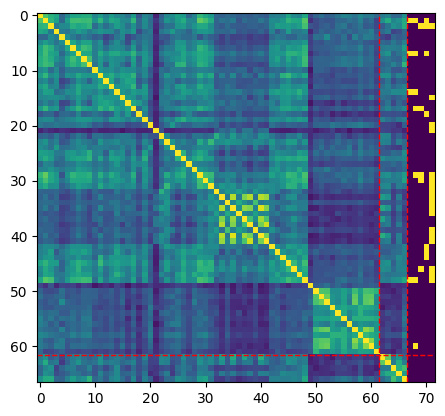

In [23]:
encodings = chunk_encoder.encode_doc(docs_names[doc_idx], return_all=True)
sections = tf.concat([encodings['encoded_chunks'], encodings['encoded_queries']], axis=0)
similarity = chunk2query_cosine_similarity(sections, sections)

chunks_num = len(encodings['encoded_chunks'])
queries_num = len(encodings['encoded_queries'])
similarity = tf.concat([similarity, tf.cast(tf.pad(encodings['chunks_labels'], [[0, queries_num], [0, 0]]), similarity.dtype)], axis=1)

plt.imshow(similarity)
plt.axhline(y=chunks_num - 0.5, color='red', linestyle='--', linewidth=1)  # Marker for query start"
plt.axvline(x=chunks_num - 0.5, color='red', linestyle='--', linewidth=1)  # Marker for query start"
plt.axvline(x=(chunks_num+queries_num) - 0.5, color='red', linestyle='--', linewidth=1)  # Marker for labels start"

average similarity: (46,)


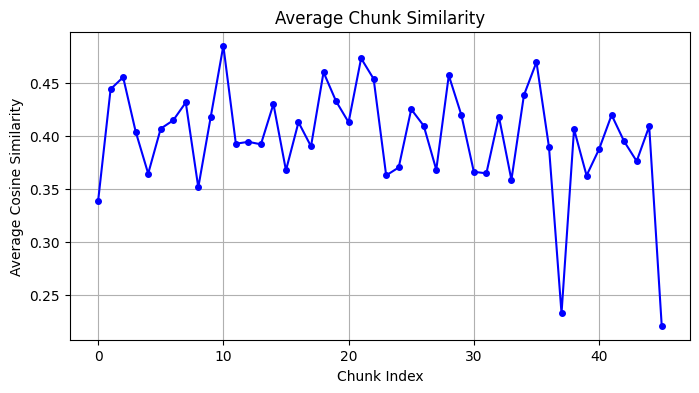

In [110]:
average_similarity = tf.reduce_mean(similarity[:len(encodings['encoded_chunks']), :len(encodings['encoded_chunks'])], axis=-1)
print('average similarity:', average_similarity.shape)

plt.figure(figsize=(8, 4))
plt.plot(average_similarity.numpy(), color='blue', marker='o', linestyle='-', markersize=4)
plt.title('Average Chunk Similarity')
plt.xlabel('Chunk Index')
plt.ylabel('Average Cosine Similarity')
plt.grid()
plt.show()

### Spectral clustering

In [4]:
from sklearn.cluster import SpectralClustering
from scipy.linalg import eigh
import numpy as np
from collections import defaultdict

def group_points_by_cluster(cluster_labels):
    """
    Groups indexes of points by their cluster numbers.
    
    Args:
        cluster_labels (list or np.ndarray): List of cluster numbers for each point.
    
    Returns:
        list of lists: Each inner list contains indexes of points belonging to the same cluster.
    """
    cluster_groups = defaultdict(list)
    
    for index, cluster in enumerate(cluster_labels):
        cluster_groups[cluster].append(index)
    
    # Convert defaultdict to a list of lists
    return list(cluster_groups.values())

def construct_weighting_kernel(similarity, sigma=1.0):
    """
    Constructs a weighting kernel for the affinity matrix.
    
    Args:
        similarity (tf.Tensor): The affinity matrix.
        sigma (float): The standard deviation for the Gaussian kernel.
    
    Returns:
        tf.Tensor: The weighting kernel.
    """
    # Get the shape of the similarity matrix
    n = similarity.shape[0]
    
    # Create a distance matrix from the diagonal
    row_indices, col_indices = np.indices((n, n))
    distance_from_diagonal = np.abs(row_indices - col_indices)
    
    # Apply Gaussian kernel
    weighting_kernel = np.exp(-distance_from_diagonal**2 / (2 * sigma**2))
    
    return tf.convert_to_tensor(weighting_kernel, dtype=similarity.dtype)


def compute_laplacian(affinity_matrix, normalized=True):
    # D is the degree matrix
    D = np.diag(np.sum(affinity_matrix, axis=1))
    L = D - affinity_matrix
    if normalized:
        # Normalized symmetric Laplacian L_sym = D^{-1/2} L D^{-1/2}
        D_inv_sqrt = np.diag(1.0 / np.sqrt(np.diag(D)))
        L = D_inv_sqrt @ L @ D_inv_sqrt
    return L

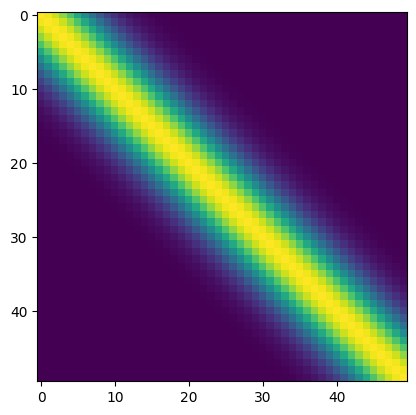

In [75]:
# Example usage
sigma = 5.0  # Adjust sigma to control the spread of weights
weighting_kernel = construct_weighting_kernel(tf.ones((50,50)), sigma=sigma)
plt.imshow(weighting_kernel)

In [106]:
doc_idx = 4
print(f"Processing document: {docs_names[doc_idx]}")
encodings = chunk_encoder.encode_doc(docs_names[doc_idx], return_all=True)
similarity = chunk2query_cosine_similarity(encodings['encoded_chunks'], encodings['encoded_chunks'])
print(f"Similarity shape: {similarity.shape}")

chunks_num = len(encodings['encoded_chunks'])
weighting_kernel = construct_weighting_kernel(similarity, sigma=sigma)
print(f"Weighting kernel shape: {weighting_kernel.shape}")

Processing document: 2403.05408v2
Similarity shape: (62, 62)
Weighting kernel shape: (62, 62)


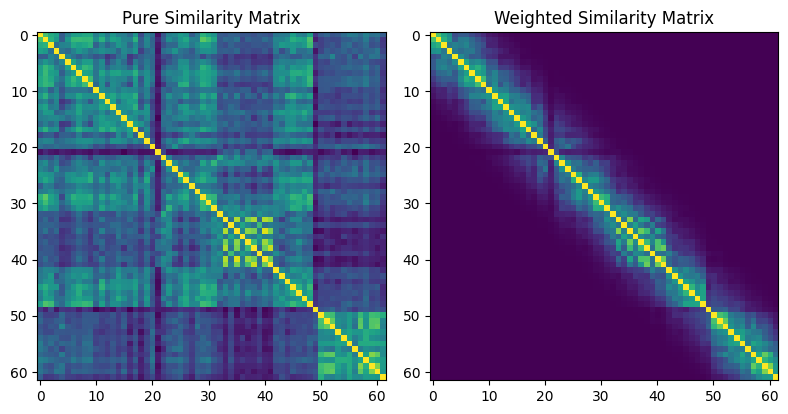

In [107]:
# plots of pure and weighted similarity matrix
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(similarity, cmap='viridis')
axs[0].set_title('Pure Similarity Matrix')
axs[1].imshow(similarity * weighting_kernel, cmap='viridis')
axs[1].set_title('Weighted Similarity Matrix')
plt.tight_layout()
plt.show()

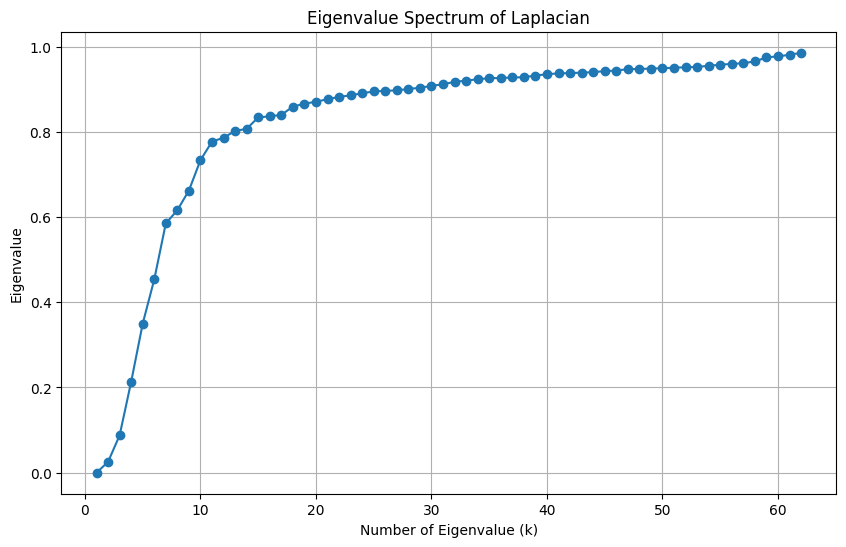

In [108]:
L = compute_laplacian((similarity * weighting_kernel).numpy(), normalized=True)

# eigh returns eigenvalues and eigenvectors in ascending order
eigenvalues, eigenvectors = eigh(L)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o')
plt.title('Eigenvalue Spectrum of Laplacian')
plt.xlabel('Number of Eigenvalue (k)')
plt.ylabel('Eigenvalue')
plt.grid(True)
plt.show()

In [109]:
clustering = SpectralClustering(
    n_clusters=np.round(chunks_num/sigma).astype(int), 
    affinity='precomputed',
    eigen_solver='arpack',
    assign_labels='discretize'
    ).fit((similarity * weighting_kernel).numpy())

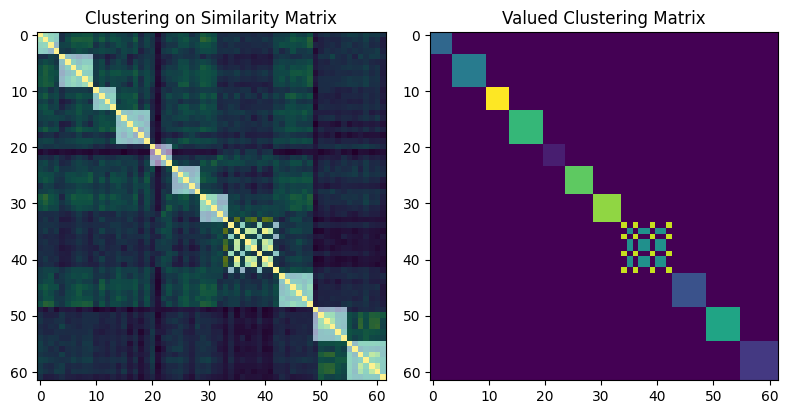

In [110]:
cls = clustering.labels_
cls_matrix = (cls[:, np.newaxis] == cls[np.newaxis, :])
valued_cls_matrix = cls_matrix*(cls[:, np.newaxis] + 1)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(similarity)
axs[0].imshow(cls_matrix, cmap='gray', alpha=0.5)
axs[0].set_title('Clustering on Similarity Matrix')
axs[1].imshow(valued_cls_matrix, cmap='viridis')
axs[1].set_title('Valued Clustering Matrix')
plt.tight_layout()
plt.show()

In [111]:
clusters_chunks_idxs = group_points_by_cluster(clustering.labels_)

In [112]:
clusters_chunks_idxs

[[0, 1, 2, 3],
 [4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13],
 [14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23],
 [24, 25, 26, 27, 28],
 [29, 30, 31, 32, 33],
 [34, 36, 39, 42],
 [35, 37, 38, 40, 41],
 [43, 44, 45, 46, 47, 48],
 [49, 50, 51, 52, 53, 54],
 [55, 56, 57, 58, 59, 60, 61]]

In [113]:
encodings['queries']

['What is Federated SAM (FedSAM)?',
 'What is Federated SAM with Medical SAM Adapter (FedMSA)?',
 'How does FedFMS maintain privacy while achieving comparable performance to centralized training?',
 'What are the communication and training efficiency benefits of FedMSA?',
 'Compare the performance of FedFMS with centralized training methods in medical image segmentation.']

In [114]:
cluster_idx = 3
cluster_chunks_idxs = clusters_chunks_idxs[cluster_idx]

cluster_chunks = [encodings['chunks'][idx] for idx in cluster_chunks_idxs]

for chunk in cluster_chunks:
    for line in chunk.split('\n'):
        print(line)
    print('---')

Figure 1 illustrates the FedFMS framework, comprising multiple clients for local
training and a server for parameter aggregation, all utilizing the same founda-
tional model (e.g., SAM or MSA). The federated learning of SAM and its more
efficient variant MSA corresponds to FedSAM and FedMSA, respectively.
Client-side Model TrainingEach client possesses a fixed local dataset and
sufficient computational resources to perform mini-batch updates. The number
of clients isK. Each client adopts the same BCE loss and the same model (SAM
---
or MSA), which is initialized with pre-trained SAM parameters before training.
FedSAMTo achieve simultaneous segmentation of multiple classes, we omit the
input prompts and prompt encoder, perform a multi-class segmentation header
4 Yuxi Liu et al.
by adopting a two-dimensional convolution with a1 ×1 kernel after the original
SAM decoder, mapping the output mask toH × W × c, wherec is the number
of segmentation classes,H is the height andW is the width of 

### clusters aggregation

In [115]:
# Collect and aggregate labels for each cluster

query_similarity = chunk2query_cosine_similarity(encodings['encoded_chunks'], encodings['encoded_queries'])
query_similarity.shape

clusters_chunks_idxs = group_points_by_cluster(clustering.labels_)

clusters_labels = []
clusters_query_sum_scores = []
clusters_query_avg_scores = []

for cluster_idxs in clusters_chunks_idxs:
    cluster_labels = [encodings['chunks_labels'][idx] for idx in cluster_idxs]
    clusters_query_scores = [query_similarity[idx, :] for idx in cluster_idxs]
    # Aggregate labels by summing them up
    aggregated_labels = tf.reduce_sum(tf.stack(cluster_labels), axis=0)
    aggregated_query_sum_scores = tf.reduce_sum(tf.stack(clusters_query_scores), axis=0)
    aggregated_query_avg_scores = tf.reduce_mean(tf.stack(clusters_query_scores), axis=0)

    clusters_labels.append(aggregated_labels)
    clusters_query_sum_scores.append(aggregated_query_sum_scores)
    clusters_query_avg_scores.append(aggregated_query_avg_scores)

clusters_labels = tf.stack(clusters_labels)
clusters_query_sum_scores = tf.stack(clusters_query_sum_scores)
clusters_query_avg_scores = tf.stack(clusters_query_avg_scores)
print(f"Clusters labels shape: {clusters_labels.shape}")
print(f"Clusters query sum scores shape: {clusters_query_sum_scores.shape}")
print(f"Clusters query avg scores shape: {clusters_query_avg_scores.shape}")

clusters_labels.numpy(), tf.where(clusters_query_avg_scores>0.40, 1, 0).numpy(), np.round(clusters_query_sum_scores), np.round(clusters_query_avg_scores, 2)

Clusters labels shape: (12, 5)
Clusters query sum scores shape: (12, 5)
Clusters query avg scores shape: (12, 5)


(array([[1, 1, 1, 2, 1],
        [1, 1, 0, 1, 0],
        [0, 0, 0, 0, 0],
        [1, 2, 1, 1, 1],
        [0, 0, 0, 0, 2],
        [0, 0, 0, 0, 0],
        [0, 1, 2, 0, 5],
        [0, 0, 0, 1, 3],
        [0, 0, 0, 0, 3],
        [1, 1, 1, 2, 3],
        [0, 0, 0, 0, 0],
        [0, 1, 0, 0, 0]], dtype=int32),
 array([[0, 1, 0, 0, 1],
        [0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1],
        [1, 1, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [1, 1, 0, 1, 0],
        [1, 1, 0, 1, 1],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]], dtype=int32),
 array([[2., 2., 1., 2., 2.],
        [2., 2., 2., 2., 3.],
        [2., 2., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [1., 1., 1., 1., 1.],
        [2., 2., 2., 2., 2.],
        [2., 2., 1., 2., 2.],
        [1., 1., 1., 1., 1.],
        [3., 2., 1., 2., 1.],
        [2., 2., 2., 3., 3.],
        [1., 1., 1., 1., 2.],
        [1., 1., 1., 1., 2.]], dtype=flo

### Clusters representation chunk

In [116]:
# Retreives a chunk that is the most representative for the cluster
# Representativeness is defined as the chunk closest to the clusters centroid
def get_cluster_centroid(cluster_idxs, encoded_chunks):
    cluster_chunks = tf.stack([encoded_chunks[idx] for idx in cluster_idxs])
    cluster_centroid = tf.reduce_mean(cluster_chunks, axis=0, keepdims=True)
    return cluster_centroid, cluster_chunks

def get_centroid_representative_chunk(cluster_idxs, encoded_chunks):
    cluster_centroid, cluster_chunks = get_cluster_centroid(cluster_idxs, encoded_chunks)
    #similarities = tf.norm(cluster_chunks - cluster_centroid, axis=1, keepdims=False)
    similarities = tf.squeeze(chunk2query_cosine_similarity(cluster_chunks, cluster_centroid), axis=1)
    most_representative_idx = tf.argmax(similarities).numpy()
    global_idx = cluster_idxs[most_representative_idx]
    return global_idx

# Get representative chunks from clusters for each query based on similarity score
def get_representative_chunks_for_queries(cluster_idxs, query_similarity):
    chunk_similarities = tf.stack([query_similarity[idx, :] for idx in cluster_idxs])
    most_representative_idxs = tf.argmax(chunk_similarities, axis=0).numpy()
    global_idxs = [cluster_idxs[idx] for idx in most_representative_idxs]
    return global_idxs


#### centroid similarity

In [117]:
clusters_chunks_idxs = group_points_by_cluster(clustering.labels_)
representational_chunks_idxs = [get_centroid_representative_chunk(cluster_chunks_idxs, encodings['encoded_chunks']) for cluster_chunks_idxs in clusters_chunks_idxs]
representational_chunks = [encodings['chunks'][idx] for idx in representational_chunks_idxs]

for chunk in representational_chunks:
    for line in chunk.split('\n'):
        print(line)
    print('---')

FedFMS: Exploring Federated Foundation Models
for Medical Image Segmentation
Yuxi Liu1, Guibo Luo1(  ), and Yuesheng Zhu1(  )
School of Electronic and Computer Engineering, Peking University, Shenzhen, China
  Correspondences: {luogb,zhuys}@pku.edu.cn
Abstract. Medical image segmentation is crucial for clinical diagnosis.
The Segmentation Anything Model (SAM) serves as a powerful foun-
dation model for visual segmentation and can be adapted for medi-
cal image segmentation. However, medical imaging data typically con-
tain privacy-sensitive information, making it challenging to train foun-
---
(1)DatasetCollection.Wehavecollectedvariousmulti-institutionaldatasets
to serve as benchmarks for evaluating the performance of federated foundation
models in medical image segmentation. This offers comprehensive and reliable
evaluation data for federated medical segmentation.
(2) Model Development. We have developed a federated learning frame-
work named FedSAM based on the foundation model SAM,

In [72]:
representational_chunks_idxs

[6, 12, 30, 38, 49]

#### question similarity

In [118]:
query_similarity = chunk2query_cosine_similarity(encodings['encoded_chunks'], encodings['encoded_queries'])
clusters_chunks_idxs = group_points_by_cluster(clustering.labels_)

representational_query_chunks_idxs = [get_representative_chunks_for_queries(cluster_chunks_idxs, query_similarity) for cluster_chunks_idxs in clusters_chunks_idxs]
representational_query_chunks_idxs

[[1, 1, 2, 1, 2],
 [7, 7, 9, 6, 9],
 [11, 11, 11, 11, 13],
 [19, 17, 14, 14, 14],
 [22, 22, 23, 23, 23],
 [26, 26, 26, 26, 25],
 [33, 29, 30, 29, 30],
 [42, 42, 42, 42, 42],
 [40, 35, 40, 40, 38],
 [46, 45, 48, 48, 48],
 [51, 54, 54, 54, 54],
 [58, 58, 58, 58, 58]]

In [119]:
cluster_idx = 2

print("Queries:")
for query in encodings['queries']:
    print(query)
print("\n-------\n")

print(f"Cluster {cluster_idx} representative chunks:\n")
for idx in representational_query_chunks_idxs[cluster_idx]:
    for line in encodings['chunks'][idx].split('\n'):
        print(line)
    print('---')

Queries:
What is Federated SAM (FedSAM)?
What is Federated SAM with Medical SAM Adapter (FedMSA)?
How does FedFMS maintain privacy while achieving comparable performance to centralized training?
What are the communication and training efficiency benefits of FedMSA?
Compare the performance of FedFMS with centralized training methods in medical image segmentation.

-------

Cluster 2 representative chunks:

𝑎
(b) MSA FrameworkSAM
Adapter
SAM / Variants
SAM
Adapter
SAM / Variants
SAM
Adapter
SAM / Variants
SAM
Adapter
SAM / Variants
Multi-class 
Segmentation Header
Original Lightweight
SAM Decoder
Lightweight
SAM 
Decoder
Fig. 1.The illustration of FedSAM and FedMSA. FedSAM is a federated learning
framework with (a) SAM. FedMSA is a federated learning framework with (b) MSA.
million masks, to drive its training. The image encoder utilizes a standard Vision
Transformer (ViT) [2,23] pre-trained by Masked Autoencoders. In our study, we
---
𝑎
(b) MSA FrameworkSAM
Adapter
SAM / Variants
SAM
Ad

### Clusters similarity

Centroids similarities shape: (12, 12)


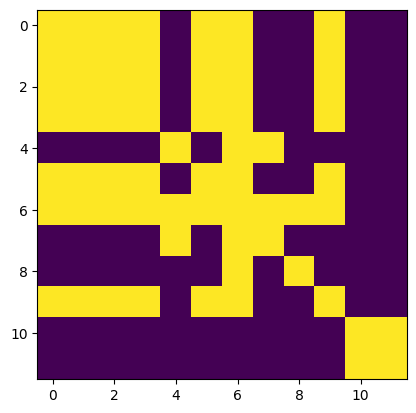

In [120]:
centroids = tf.concat([get_cluster_centroid(cluster_chunks_idxs, encodings['encoded_chunks'])[0] for cluster_chunks_idxs in clusters_chunks_idxs], axis=0)

centroids_similarities = chunk2query_cosine_similarity(centroids, centroids)
print(f"Centroids similarities shape: {centroids_similarities.shape}")

plt.imshow(tf.where(centroids_similarities>0.65,1,0), cmap='viridis')

In [121]:
clusters_labels.numpy()

array([[1, 1, 1, 2, 1],
       [1, 1, 0, 1, 0],
       [0, 0, 0, 0, 0],
       [1, 2, 1, 1, 1],
       [0, 0, 0, 0, 2],
       [0, 0, 0, 0, 0],
       [0, 1, 2, 0, 5],
       [0, 0, 0, 1, 3],
       [0, 0, 0, 0, 3],
       [1, 1, 1, 2, 3],
       [0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0]], dtype=int32)